# Big Project
## Group 10 - Data Under Construction

### Setup Notebook

In [3]:
!pip install geopandas

In [7]:
# Import 3rd party libraries
import os
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import matplotlib.patches as mpatches

# Configure Notebook
%matplotlib inline 
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

In [9]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [11]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate

In [13]:
from sklearn.inspection import permutation_importance

### 1. Collecting and Cleaning Data 

#### 1.1 Neighbourhoods Data

First, we need the Toronto Neighborhoods geodata to locate the different listings in their specific neighborhoods. To do so, we will use the Boundaries of Toronto Neighbourhoods files from Toronto Open Data.

In [18]:
# Load the shapefile (use the path to the .shp file)
neighbourhoods = gpd.read_file('Neighbourhoods - 4326.shp')

In [20]:
# Display the first few rows of the neighbourhoods GeoDataFrame
neighbourhoods.head()

,_id1,AREA_ID2,AREA_AT3,PARENT_4,AREA_SH5,AREA_LO6,AREA_NA7,AREA_DE8,CLASSIF9,CLASSIF10,OBJECTI11,geometry
0,1,2502366,26022881,0,174,174,South Eglinton-Davisville,South Eglinton-Davisville (174),Not an NIA or Emerging Neighbourhood,NA,17824737.0,"POLYGON ((-79.38635 43.69783, -79.38623 43.697..."
1,2,2502365,26022880,0,173,173,North Toronto,North Toronto (173),Not an NIA or Emerging Neighbourhood,NA,17824753.0,"POLYGON ((-79.39744 43.70693, -79.39837 43.706..."
2,3,2502364,26022879,0,172,172,Dovercourt Village,Dovercourt Village (172),Not an NIA or Emerging Neighbourhood,NA,17824769.0,"POLYGON ((-79.43411 43.66015, -79.43537 43.659..."
3,4,2502363,26022878,0,171,171,Junction-Wallace Emerson,Junction-Wallace Emerson (171),Not an NIA or Emerging Neighbourhood,NA,17824785.0,"POLYGON ((-79.4387 43.66766, -79.43841 43.6669..."
4,5,2502362,26022877,0,170,170,Yonge-Bay Corridor,Yonge-Bay Corridor (170),Not an NIA or Emerging Neighbourhood,NA,17824801.0,"POLYGON ((-79.38404 43.64497, -79.38502 43.644..."


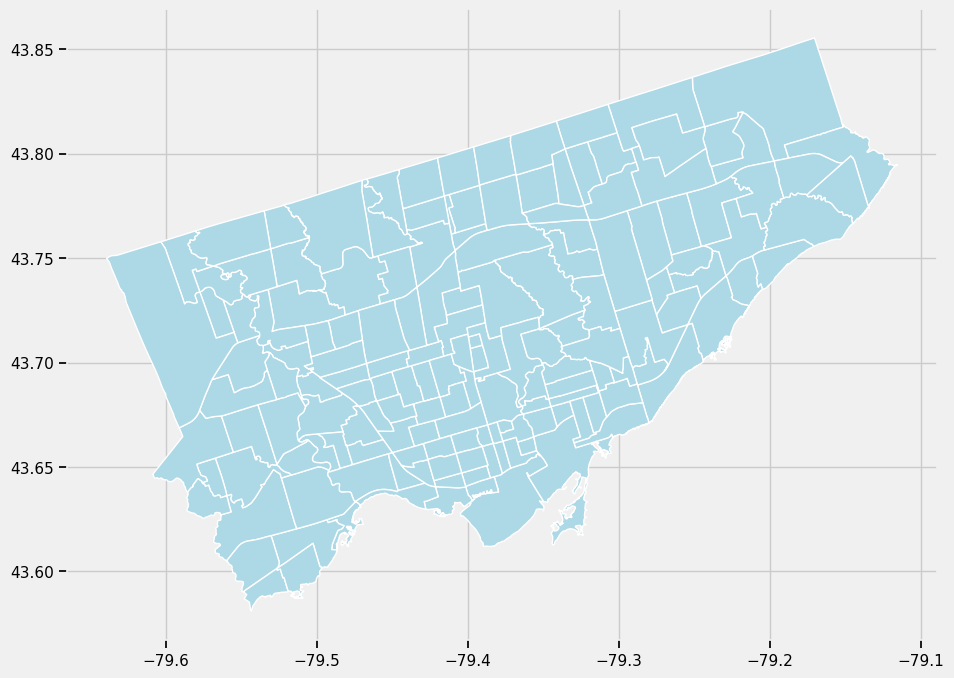

In [22]:
# Plot the neighborhoods
fig, ax = plt.subplots(figsize=(10, 10))
neighbourhoods.plot(ax=ax, color='lightblue', edgecolor='white')
plt.show()

Next, we will create a dictionary for the ranking of neighborhoods. This ranking is from the Toronto Life website, and it is based on 10 different factors including Safety, Community, Transit, ...etc.

In [25]:
# Define the neighborhood ranking as a dictionary
neighbourhood_ranking = {
    'Danforth': 1,
    'West Queen West': 2,
    'Runnymede-Bloor West Village': 3,
    'Avondale': 4,
    'Wellington Place': 5,
    'Yonge-Doris': 6,
    'Cabbagetown-South St.James Town': 7,
    'Bay-Cloverhill': 8,
    'Palmerston-Little Italy': 9,
    'Trinity-Bellwoods': 10,
    'Bridle Path-Sunnybrook-York Mills': 11,
    'Annex': 12,
    'North Riverdale': 13,
    'Mount Pleasant East': 14,
    'Lawrence Park North': 15,
    'Kingsway South': 16,
    'University': 17,
    'Yonge-Bay Corridor': 18,
    'Leaside-Bennington': 19,
    'South Eglinton-Davisville': 20,
    'Harbourfront-CityPlace': 21,
    'Wychwood': 22,
    'Dovercourt Village': 23,
    'Blake-Jones': 24,
    'Roncesvalles': 25,
    'Dufferin Grove': 26,
    'Lawrence Park South': 27,
    'Church-Wellesley': 28,
    'Casa Loma': 29,
    'Woodbine-Lumsden': 30,
    'Danforth East York': 31,
    'Regent Park': 32,
    'Lansing-Westgate': 33,
    'Downtown Yonge East': 34,
    'St Lawrence-East Bayfront-The Islands': 35,
    'Yonge-Eglinton': 36,
    'High Park-Swansea': 37,
    'Little Portugal': 38,
    'Forest Hill South': 39,
    'Playter Estates-Danforth': 40,
    'Junction Area': 41,
    'Woodbine Corridor': 42,
    'The Beaches': 43,
    'Rosedale-Moore Park': 44,
    'Old East York': 45,
    'Bedford Park-Nortown': 46,
    'High Park North': 47,
    'Kensington-Chinatown': 48,
    'Yonge-St.Clair': 49,
    'Junction-Wallace Emerson': 50,
    'Princess-Rosethorn': 51,
    'Fort York-Liberty Village': 52,
    'North St.James Town': 53,
    'Willowdale West': 54,
    'North Toronto': 55,
    'Greenwood-Coxwell': 56,
    'Bayview Village': 57,
    'South Riverdale': 58,
    'Humewood-Cedarvale': 59,
    'East End-Danforth': 60,
    'Taylor-Massey': 61,
    'East Willowdale': 62,
    'Corso Italia-Davenport': 63,
    'Etobicoke City Centre': 64,
    'Stonegate-Queensway': 65,
    'Centennial Scarborough': 66,
    'Hillcrest Village': 67,
    'Humber Bay Shores': 68,
    'Moss Park': 69,
    'Broadview North': 70,
    'Morningside Heights': 71,
    'Lambton Baby Point': 72,
    'Newtonbrook East': 73,
    'Malvern West': 74,
    'Forest Hill North': 75,
    'Clanton Park': 76,
    'Pleasant View': 77,
    'Banbury-Don Mills': 78,
    'Malvern East': 79,
    'Islington': 80,
    'Markland Wood': 81,
    'Highland Creek': 82,
    'Agincourt North': 83,
    'Edenbridge-Humber Valley': 84,
    'East L\'Amoreaux': 85,
    'Alderwood': 86,
    'Milliken': 87,
    'Henry Farm': 88,
    'Steeles': 89,
    'St.Andrew-Windfields': 90,
    'Pelmo Park-Humberlea': 91,
    'Guildwood': 92,
    'Oakwood Village': 93,
    'Agincourt South-Malvern West': 94,
    'Birchcliffe-Cliffside': 95,
    'Clairlea-Birchmount': 96,
    'Englemount-Lawrence': 97,
    'West Rouge': 98,
    'Tam O\'Shanter-Sullivan': 99,
    'Briar Hill-Belgravia': 100,
    'Bayview Woods-Steeles': 101,
    'Weston-Pelham Park': 102,
    'Bathurst Manor': 103,
    'Woburn North': 104,
    'Bendale South': 105,
    'Newtonbrook West': 106,
    'L\'Amoreaux West': 107,
    'Eringate-Centennial-West Deane': 108,
    'Flemingdon Park': 109,
    'Westminster-Branson': 110,
    'Don Valley Village': 111,
    'Long Branch': 112,
    'Caledonia-Fairbank': 113,
    'Humber Heights-Westmount': 114,
    'Parkwoods-O\'Connor Hills': 115,
    'Rockcliffe-Smythe': 116,
    'Thistletown-Beaumond Heights': 117,
    'Keelesdale-Eglinton West': 118,
    'Maple Leaf': 119,
    'O\'Connor-Parkview': 120,
    'Etobicoke West Mall': 121,
    'Morningside': 122,
    'Mimico-Queensway': 123,
    'Bendale-Glen Andrew': 124,
    'Oakridge': 125,
    'Dorset Park': 126,
    'Thorncliffe Park': 127,
    'Wexford/Maryvale': 128,
    'Victoria Village': 129,
    'Elms-Old Rexdale': 130,
    'Cliffcrest': 131,
    'Humbermede': 132,
    'Mount Dennis': 133,
    'Ionview': 134,
    'Willowridge-Martingrove-Richview': 135,
    'Downsview': 136,
    'Kingsview Village-The Westway': 137,
    'Eglinton East': 138,
    'Fenside-Parkwoods': 139,
    'Yorkdale-Glen Park': 140,
    'Mount Olive-Silverstone-Jamestown': 141,
    'West Humber-Clairville': 142,
    'Glenfield-Jane Heights': 143,
    'South Parkdale': 144,
    'York University Heights': 145,
    'New Toronto': 146,
    'Golfdale-Cedarbrae-Woburn': 147,
    'Brookhaven-Amesbury': 148,
    'Rexdale-Kipling': 149,
    'Rustic': 150,
    'Humber Summit': 151,
    'Scarborough Village': 152,
    'Beechborough-Greenbrook': 153,
    'Oakdale-Beverley Heights': 154,
    'Weston': 155,
    'West Hill': 156,
    'Black Creek': 157,
    'Kennedy Park': 158
}

#### 1.2 Zillow Rent Data

Zillow website offers many csv files for rental listings. Five files were imported as shown below.

In [29]:
# Load each CSV file
zillow_one = pd.read_csv('zillow-one.csv')

In [31]:
zillow_one.head()

,Property URL,Property type,Number of days on Zillow,Date listed (MM/DD/YYYY),Rental price (USD per month),Living area,Living area unit,Price per living area unit (USD),Bedrooms,Bathrooms,...,Property unit number,Street address,City,Zip,Latitude,Longitude,Zillow property ID,Property is a building,Building name,Unit availability count
0,https://www.zillow.com/homedetails/413-Markham...,Apartment,2.0,11/04/2024,2400.0,900.0,sqft,2.67,1.0,1.0,...,NaN,413 Markham St,Toronto,NaN,43.660350,-79.410310,2063459583,NaN,NaN,NaN
1,https://www.zillow.com/homedetails/1221-King-S...,Apartment,2.0,11/04/2024,2200.0,500.0,sqft,4.40,1.0,1.0,...,# 7026,1221 King St W,Toronto,NaN,43.638584,-79.427666,2054131263,NaN,NaN,NaN
2,https://www.zillow.com/homedetails/47-Lower-Ri...,Apartment,2.0,11/04/2024,2200.0,500.0,sqft,4.40,1.0,1.0,...,NaN,47 Lower River St,Toronto,NaN,43.656498,-79.355540,2079696219,NaN,NaN,NaN
3,https://www.zillow.com/b/1350-ellesmere-rd-tor...,Building,3.0,11/03/2024,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1350 Ellesmere Rd,Toronto,NaN,43.770374,-79.261860,43.770374--79.26186,Yes,Red-Three Building (Randomly generated buildin...,3.0
4,https://www.zillow.com/b/1350-ellesmere-rd-tor...,Apartment,NaN,NaN,2200.0,NaN,NaN,NaN,1.0,NaN,...,NaN,1350 Ellesmere Rd,Toronto,NaN,NaN,NaN,NaN,No,Unit located in: Red-Three Building,NaN


In [33]:
zillow_one.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Property URL                      1188 non-null   object 
 1   Property type                     1188 non-null   object 
 2   Number of days on Zillow          736 non-null    float64
 3   Date listed (MM/DD/YYYY)          736 non-null    object 
 4   Rental price (USD per month)      819 non-null    float64
 5   Living area                       95 non-null     float64
 6   Living area unit                  95 non-null     object 
 7   Price per living area unit (USD)  95 non-null     float64
 8   Bedrooms                          819 non-null    float64
 9   Bathrooms                         450 non-null    float64
 10  Image URL                         811 non-null    object 
 11  Is owner occupied                 450 non-null    object 
 12  Proper

In [35]:
# Filter the DataFrame to keep only rows with non-null values in the "Living area" column and "latitude" column
Zillow_one_filtered = zillow_one[zillow_one['Living area'].notnull()]
Zillow_one_filtered = Zillow_one_filtered.dropna(subset=['Latitude'])

# Select only specific columns (Note that the rental price is in CAD but Zillow mistakenly write it in USD)
Zillow_one_filtered = Zillow_one_filtered[['Rental price (USD per month)', 'Living area', 
                           'Bedrooms', 'Bathrooms', 'Street address', 'Latitude', 'Longitude','Zillow property ID']]

# Rename specific columns
Zillow_one_filtered = Zillow_one_filtered.rename(columns={'Rental price (USD per month)': 'Rent Price (CAD)',
                                                          'Living area': 'Living Area (sqft)',
                                                          'Street address': 'Address',
                                                          'Zillow property ID': 'Listing ID'})

# Perform a spatial join to add the neighborhood name (from AREA_NA7) to each apartment
geometry = [Point(xy) for xy in zip(Zillow_one_filtered['Longitude'], Zillow_one_filtered['Latitude'])]
Zillow_one_filtered = gpd.GeoDataFrame(Zillow_one_filtered, geometry=geometry, crs='EPSG:4326')
Zillow_one_hood = gpd.sjoin(Zillow_one_filtered, neighbourhoods, how="left", predicate="within")

# Assign the neighborhood name from AREA_NA7 to a new column in the filtered DataFrame
Zillow_one_filtered['Neighbourhood'] = Zillow_one_hood['AREA_NA7']

# Map the ranks to the 'Neighbourhood' column in filtered_gdf
Zillow_one_filtered['Neighbourhood Rank'] = Zillow_one_filtered['Neighbourhood'].map(neighbourhood_ranking)

# Rearrange columns
Zillow_one_filtered = Zillow_one_filtered[['Listing ID',
                                           'Address',
                                           'Bedrooms',
                                           'Bathrooms',
                                           'Living Area (sqft)',
                                           'Latitude',
                                           'Longitude',
                                           'Neighbourhood',
                                           'Neighbourhood Rank',
                                           'Rent Price (CAD)']]

Zillow_one_filtered = Zillow_one_filtered.reset_index(drop=True)

In [37]:
# Display the filtered DataFrame info to verify
Zillow_one_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Listing ID          91 non-null     object 
 1   Address             91 non-null     object 
 2   Bedrooms            91 non-null     float64
 3   Bathrooms           91 non-null     float64
 4   Living Area (sqft)  91 non-null     float64
 5   Latitude            91 non-null     float64
 6   Longitude           91 non-null     float64
 7   Neighbourhood       91 non-null     object 
 8   Neighbourhood Rank  91 non-null     int64  
 9   Rent Price (CAD)    91 non-null     float64
dtypes: float64(6), int64(1), object(3)
memory usage: 7.2+ KB


#### 1.3 TRREB Rent Data

Refer to the TRREB notebook for the process of collecting the TRREB Rent Data.

In [44]:
trreb = pd.read_csv('TRREB_data_final.csv')

In [46]:
trreb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3356 entries, 0 to 3355
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   address             3356 non-null   object 
 1   beds                3356 non-null   object 
 2   baths               3356 non-null   int64  
 3   type                3356 non-null   object 
 4   price               3356 non-null   int64  
 5   sqft                3356 non-null   object 
 6   listing#            3356 non-null   object 
 7   sqft_min            3356 non-null   int64  
 8   sqft_max            3356 non-null   int64  
 9   sqft_avg            3356 non-null   float64
 10  Type                3356 non-null   object 
 11  Style               3356 non-null   object 
 12  LAT                 3355 non-null   float64
 13  LONG                3355 non-null   float64
 14  Neighbourhood       3355 non-null   object 
 15  Neighbourhood Rank  3355 non-null   float64
dtypes: flo

In [48]:
# Select only specific columns
trreb_filtered = trreb[['price', 'sqft_avg', 'beds', 'baths', 'address',
                        'LAT', 'LONG','listing#', 'Neighbourhood','Neighbourhood Rank']]

# Rename specific columns
trreb_filtered = trreb_filtered.rename(columns={'price': 'Rent Price (CAD)',
                                                'sqft_avg': 'Living Area (sqft)',
                                                'address': 'Address',
                                                'listing#': 'Listing ID',
                                                'LAT': 'Latitude',
                                                'LONG': 'Longitude',
                                                'beds': 'Bedrooms',
                                                'baths': 'Bathrooms'})

# Rearrange columns
trreb_filtered = trreb_filtered[['Listing ID',
                                           'Address',
                                           'Bedrooms',
                                           'Bathrooms',
                                           'Living Area (sqft)',
                                           'Latitude',
                                           'Longitude',
                                           'Neighbourhood',
                                           'Neighbourhood Rank',
                                           'Rent Price (CAD)']]

trreb_filtered = trreb_filtered.reset_index(drop=True)

In [50]:
# Display the filtered DataFrame info to verify
trreb_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3356 entries, 0 to 3355
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Listing ID          3356 non-null   object 
 1   Address             3356 non-null   object 
 2   Bedrooms            3356 non-null   object 
 3   Bathrooms           3356 non-null   int64  
 4   Living Area (sqft)  3356 non-null   float64
 5   Latitude            3355 non-null   float64
 6   Longitude           3355 non-null   float64
 7   Neighbourhood       3355 non-null   object 
 8   Neighbourhood Rank  3355 non-null   float64
 9   Rent Price (CAD)    3356 non-null   int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 262.3+ KB


#### 1.4 Combined Data

In [53]:
# Combine into one dataframe
combined_data = pd.concat([Zillow_one_filtered, trreb_filtered], ignore_index=True)

# Display the combined DataFrame info to verify
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3447 entries, 0 to 3446
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Listing ID          3447 non-null   object 
 1   Address             3447 non-null   object 
 2   Bedrooms            3447 non-null   object 
 3   Bathrooms           3447 non-null   float64
 4   Living Area (sqft)  3447 non-null   float64
 5   Latitude            3446 non-null   float64
 6   Longitude           3446 non-null   float64
 7   Neighbourhood       3446 non-null   object 
 8   Neighbourhood Rank  3446 non-null   float64
 9   Rent Price (CAD)    3447 non-null   float64
dtypes: float64(6), object(4)
memory usage: 269.4+ KB


In [55]:
combined_data['Bedrooms'].unique()

array([1.0, '1', '1+1', '1+0', '1+2'], dtype=object)

In [57]:
# Convert numeric '1.0' and string '1' to '1+0', leave others as is
combined_data['Bedrooms'] = combined_data['Bedrooms'].apply(lambda x: '1+0' if str(x) in ['1.0', '1'] else x)

In [59]:
# Check the conversion
combined_data['Bedrooms'].unique()

array(['1+0', '1+1', '1+2'], dtype=object)

In [61]:
# Export the combined DataFrame to a CSV file
combined_data.to_csv('Final Data.csv', index=False)

print("Data exported successfully to 'Final Data.csv'")

Data exported successfully to 'Final Data.csv'


### 2. Exploratory Data Analysis

The data collection/cleaning section above created one single clean csv file, which will be used here.

In [244]:
df = pd.read_csv('Final Data.csv')
df = df.dropna()

In [246]:
df.head()

,Listing ID,Address,Bedrooms,Bathrooms,Living Area (sqft),Latitude,Longitude,Neighbourhood,Neighbourhood Rank,Rent Price (CAD)
0,2063459583,413 Markham St,1+0,1.0,900.0,43.660350,-79.410310,Palmerston-Little Italy,9.0,2400.0
1,2054131263,1221 King St W,1+0,1.0,500.0,43.638584,-79.427666,South Parkdale,144.0,2200.0
2,2079696219,47 Lower River St,1+0,1.0,500.0,43.656498,-79.355540,Moss Park,69.0,2200.0
3,442326900,120 Rowntree Mill Rd,1+0,1.0,800.0,43.753500,-79.577644,Humber Summit,151.0,1645.0
4,442260890,1100 Sheppard Ave W,1+0,1.0,626.0,43.751930,-79.466700,York University Heights,145.0,2400.0


In [161]:
df.shape

(3446, 10)

#### 2.1 General Distribution Plots

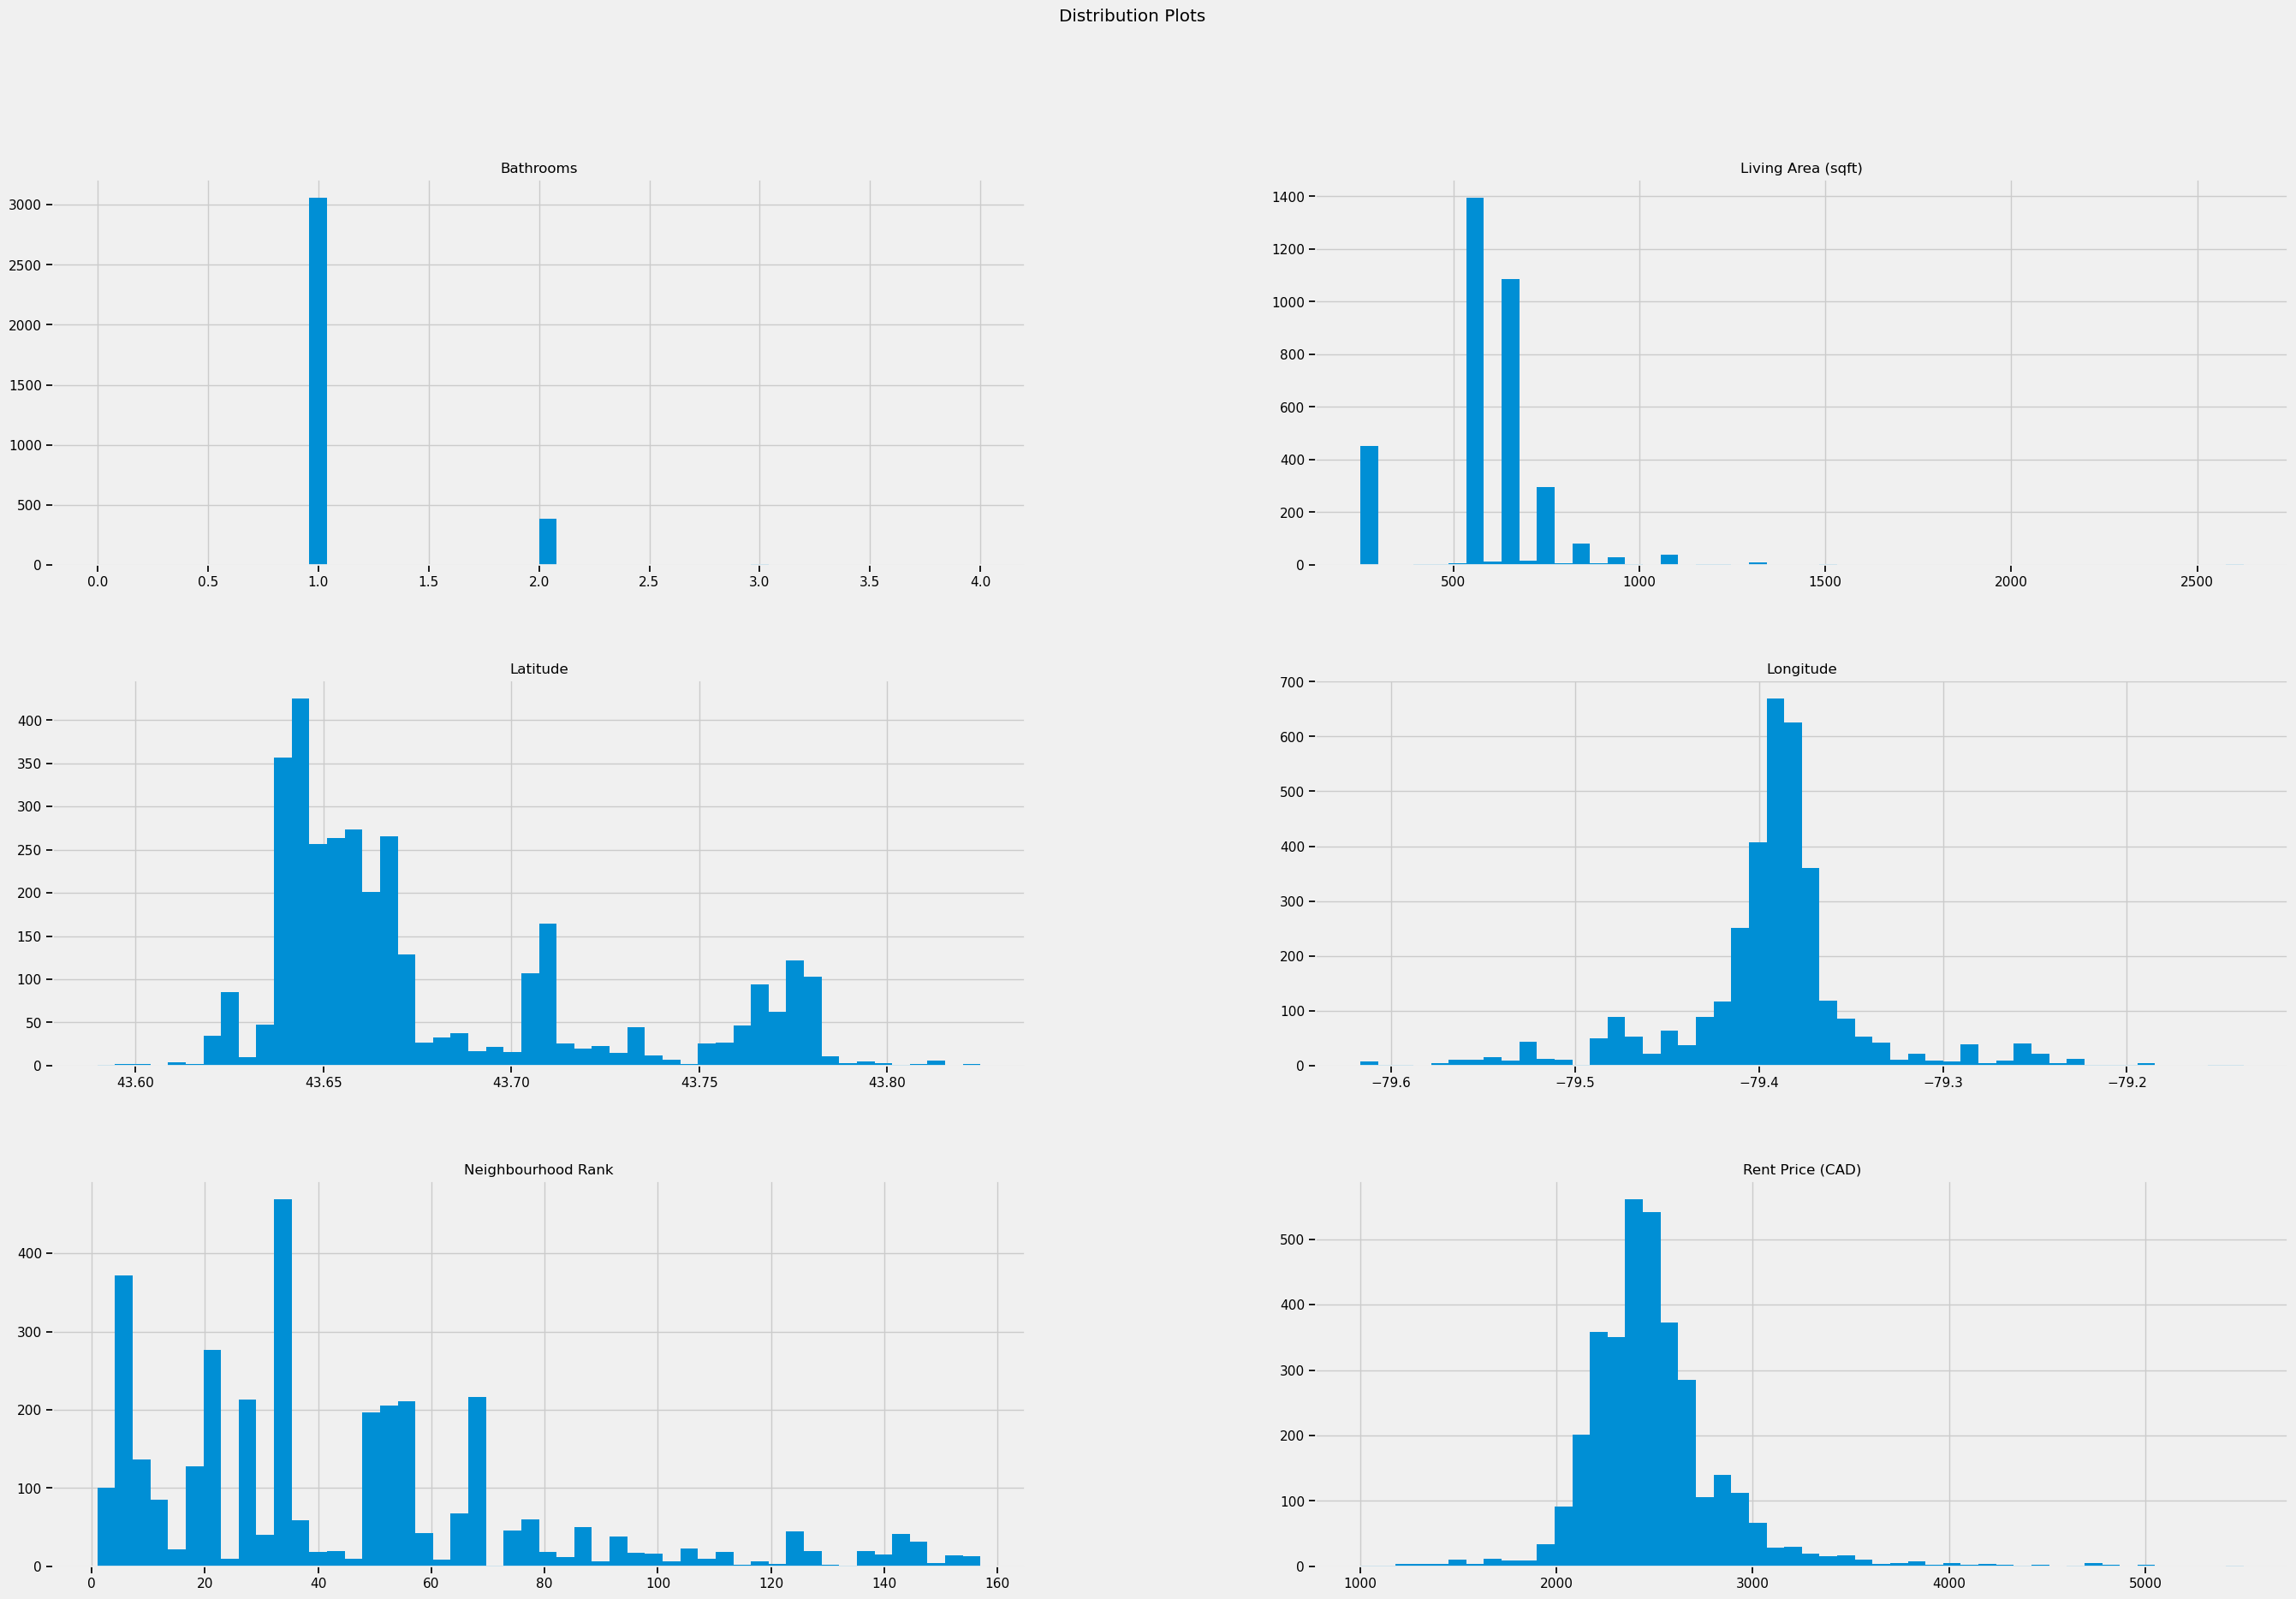

In [164]:
df.hist(bins=50, figsize=(30, 20))
plt.suptitle('Distribution Plots')
plt.show()

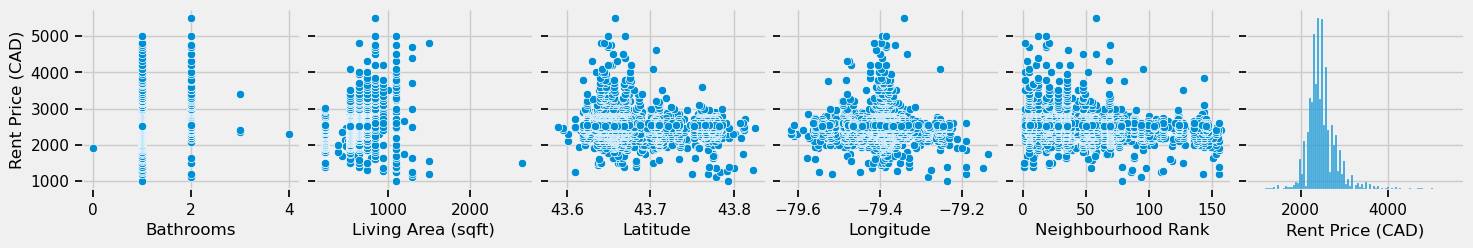

In [165]:
sns.pairplot(df, y_vars=['Rent Price (CAD)'], x_vars=df.select_dtypes(['number']).columns)

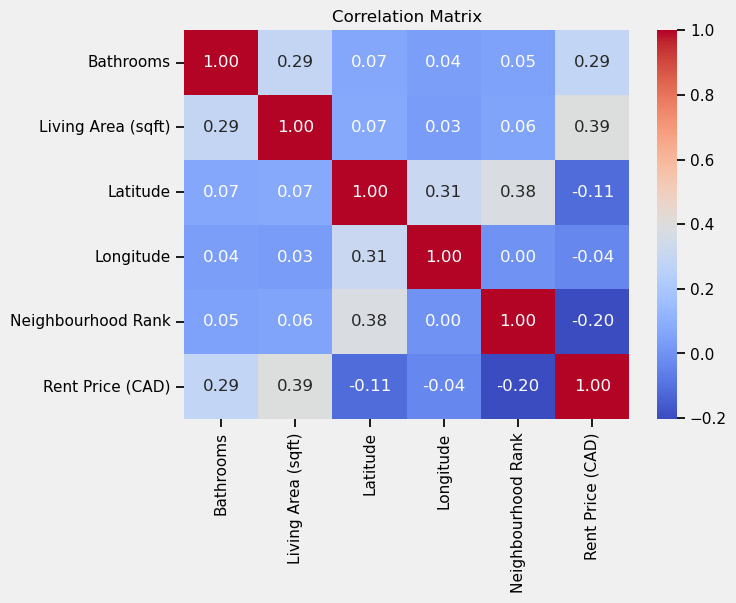

In [167]:
sns.heatmap(df.select_dtypes(['number']).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

#### 2.2 Distribution of Rent Prices

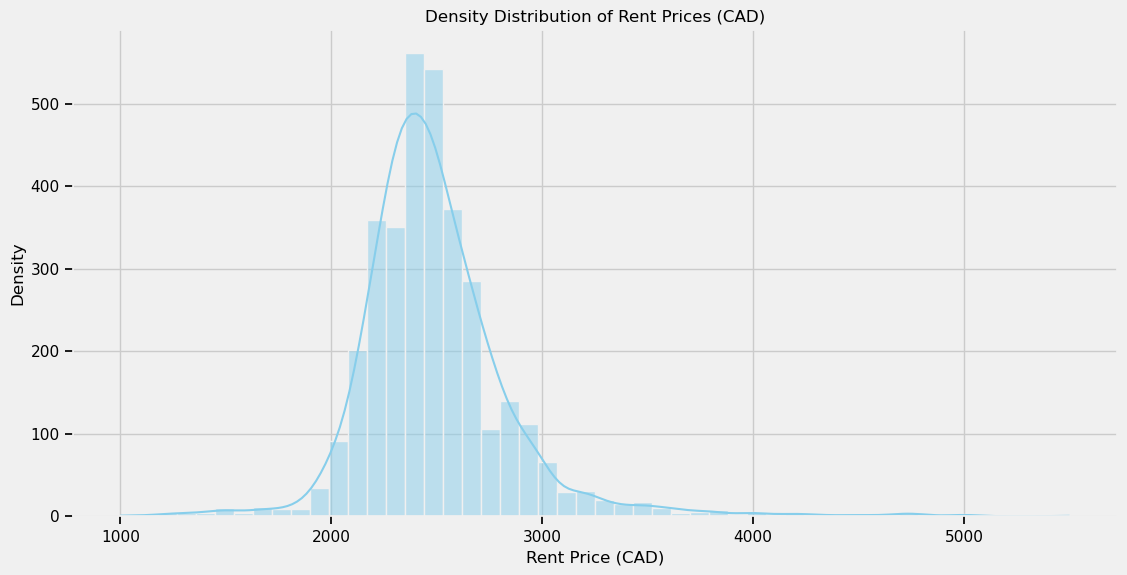

In [171]:
# Plot the distribution of rental prices
plt.figure(figsize=(12, 6))
sns.histplot(df['Rent Price (CAD)'], kde=True, color="skyblue", bins=50)
plt.xlabel('Rent Price (CAD)')
plt.ylabel('Density')
plt.title('Density Distribution of Rent Prices (CAD)')
plt.show()

AS seen above, the most common rent price is around 2400$ with normal distribution.

#### 2.3 Location Distribution of Rent Listings

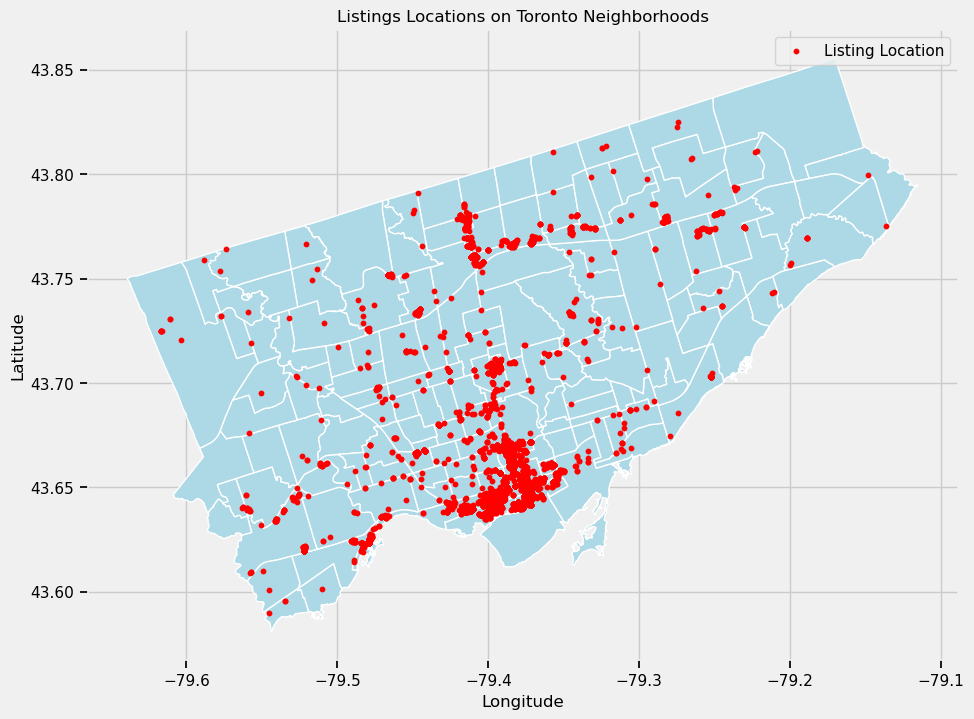

In [175]:
# Plot neighborhoods
fig, ax = plt.subplots(figsize=(10, 10))
neighbourhoods.plot(ax=ax, color='lightblue', edgecolor='white')

# Plot listings' locations
plt.scatter(df['Longitude'],df['Latitude'], color='red', s=10, label="Listing Location")

# Add labels and legend
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title("Listings Locations on Toronto Neighborhoods")

plt.show()

Most of the listings are in downtown Toronto, so when we do the train/test split we will make sure the train, val, and test have the same porportion of listings from downtown.

#### 2.4 Relations between Features and Target (Rent Price).

**Living Area and Rent Price**

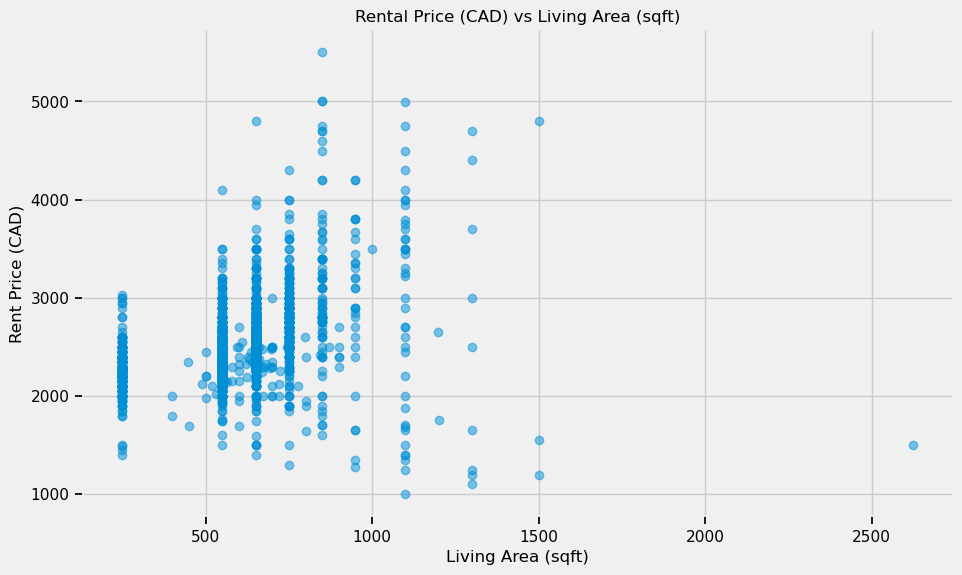

In [180]:
# Plot Rental price vs Living area
plt.figure(figsize=(10, 6))
plt.scatter(df['Living Area (sqft)'], df['Rent Price (CAD)'], alpha=0.5)
plt.xlabel('Living Area (sqft)')
plt.ylabel('Rent Price (CAD)')
plt.title('Rental Price (CAD) vs Living Area (sqft)')
plt.show()

There seems to be some outliers. They will be checked individualy via going to their listings page and verifiying if it is correct. Also there seems to be only 7 different areas for the Toronto Realistate Board data this my be a problem.

In [183]:
# Filter for outliers: price above 5000 or area above 2000
outliers = df[(df['Rent Price (CAD)'] > 5000) | (df['Living Area (sqft)'] > 2000)]

# Display each outlier's information in a single row format
for index, row in outliers.iterrows():
    print(f"URL: {row['Address']}, Price: {row['Rent Price (CAD)']}, Area: {row['Living Area (sqft)']} sqft")

URL: 6A Leaside Park Dr Toronto, Price: 1500.0, Area: 2624.5 sqft
URL: 150 Logan Ave 233 Toronto, Price: 5500.0, Area: 849.5 sqft


The 5500 CAD listing is correct.

The 1500 CAD living area is misleading since it is the area of the full house, while a one-bedroom is rented only. So, it will be deleted.

In [186]:
# Filter out the '6A Leaside Park Dr Toronto' listing
df = df[df['Living Area (sqft)'] <= 2000].reset_index(drop=True)

In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3445 entries, 0 to 3444
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Listing ID          3445 non-null   object 
 1   Address             3445 non-null   object 
 2   Bedrooms            3445 non-null   object 
 3   Bathrooms           3445 non-null   float64
 4   Living Area (sqft)  3445 non-null   float64
 5   Latitude            3445 non-null   float64
 6   Longitude           3445 non-null   float64
 7   Neighbourhood       3445 non-null   object 
 8   Neighbourhood Rank  3445 non-null   float64
 9   Rent Price (CAD)    3445 non-null   float64
dtypes: float64(6), object(4)
memory usage: 269.3+ KB


**Number of bedrooms and price**

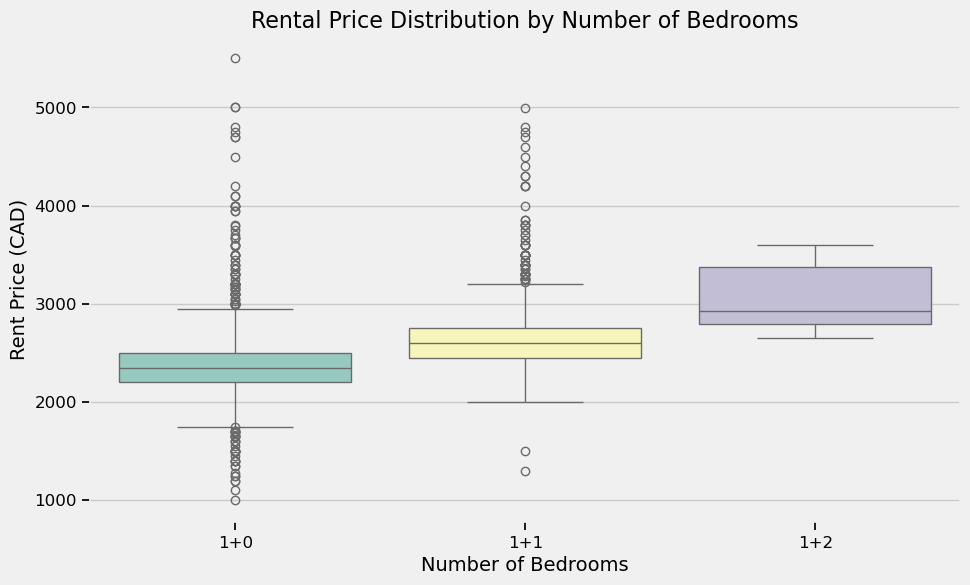

In [191]:
# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Bedrooms', y='Rent Price (CAD)', palette='Set3')

# Customize the plot
plt.title('Rental Price Distribution by Number of Bedrooms', fontsize=16)
plt.xlabel('Number of Bedrooms', fontsize=14)
plt.ylabel('Rent Price (CAD)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

**Number of Bathrooms and Rent Price**

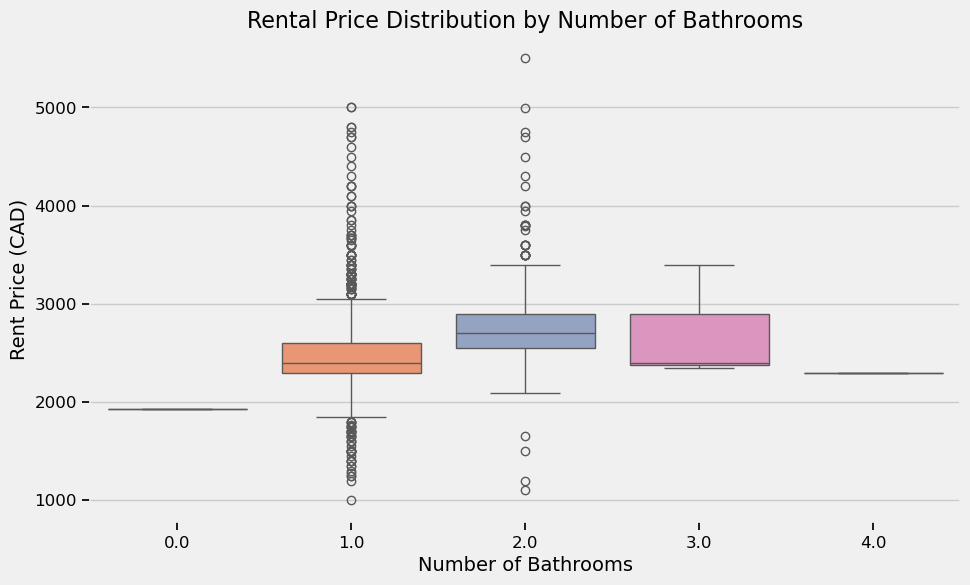

In [194]:
# Create the box plot for Bathrooms
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Bathrooms', y='Rent Price (CAD)', palette='Set2')

# Customize the plot
plt.title('Rental Price Distribution by Number of Bathrooms', fontsize=16)
plt.xlabel('Number of Bathrooms', fontsize=14)
plt.ylabel('Rent Price (CAD)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

**Neighbourhood Rank and Rent Price**

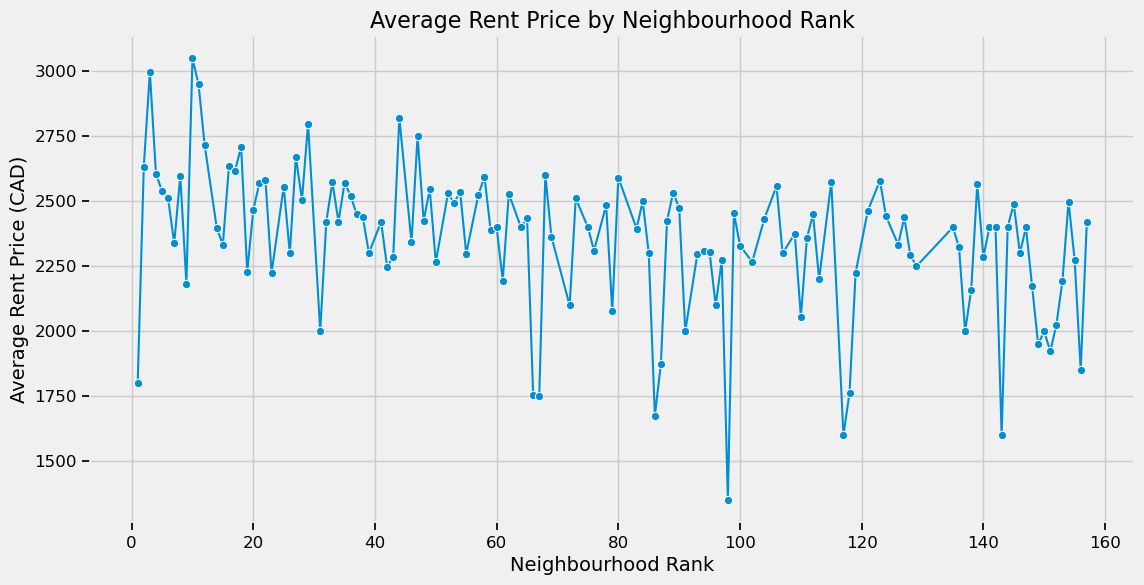

In [197]:
# Calculate the average rental price by neighborhood rank
avg_price_by_rank = df.groupby('Neighbourhood Rank')['Rent Price (CAD)'].mean().reset_index()

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_price_by_rank, x='Neighbourhood Rank', y='Rent Price (CAD)', marker='o')

# Customize the plot
plt.title('Average Rent Price by Neighbourhood Rank', fontsize=16)
plt.xlabel('Neighbourhood Rank', fontsize=14)
plt.ylabel('Average Rent Price (CAD)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

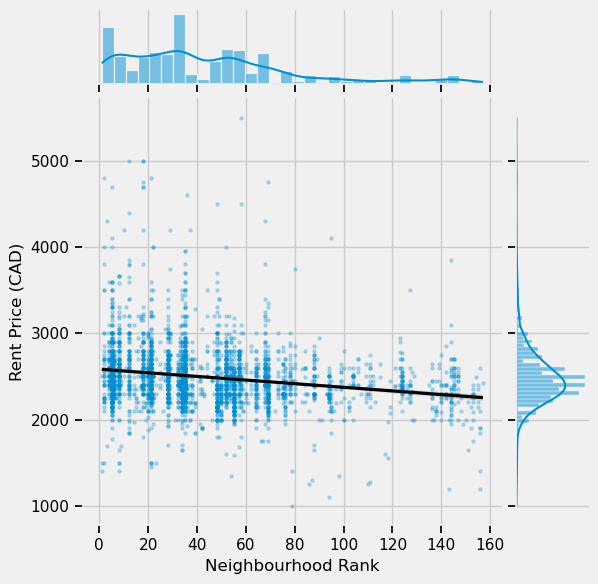

In [199]:
sns.jointplot(data=df, x='Neighbourhood Rank', y='Rent Price (CAD)', kind='reg', scatter_kws={'s': 5, 'alpha': 0.25}, line_kws={'color': 'black'})
plt.show()

The trend is not always true but it seems that the expensive averages are in the higher ranked neighbourhoods.

### Distance to U of T and price

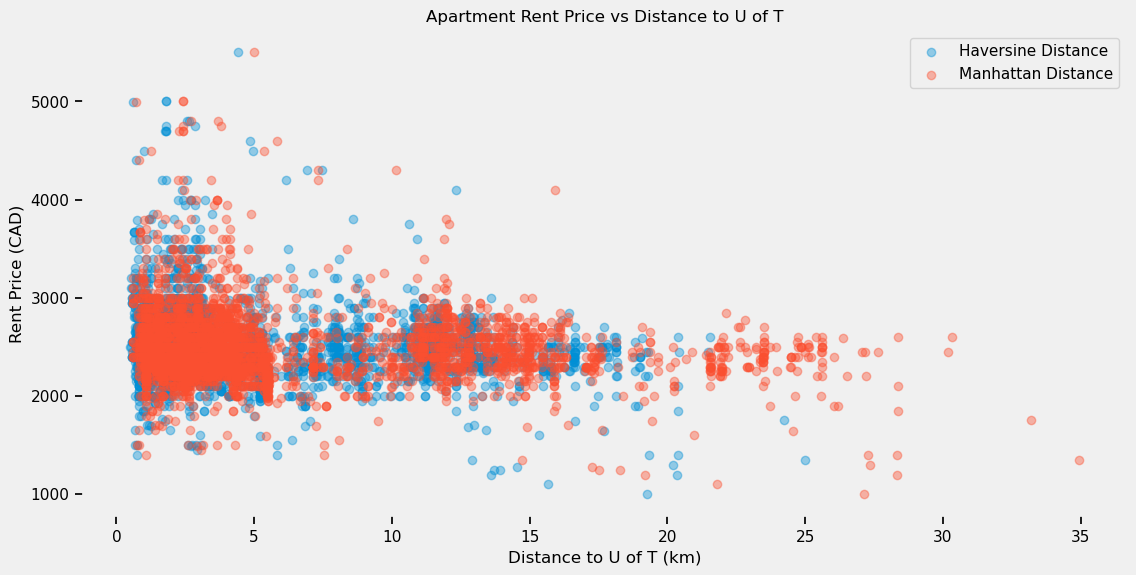

In [203]:
import matplotlib.pyplot as plt

# Define conversion factors for degrees to kilometers
lat_km_per_deg = 111  # 1 degree of latitude is approximately 111 km
lon_km_per_deg = lambda lat: 111 * np.cos(np.radians(lat))  # Longitude scaling by latitude

# U of T's coordinates
u_of_t_lat = 43.66362427073241
u_of_t_lon = -79.39586940102717

# Define functions for Haversine and Manhattan distances
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

def manhattan_distance(lat1, lon1, lat2, lon2):
    lon_km = lon_km_per_deg((lat1 + lat2) / 2)  # Average latitude for accuracy
    return (abs(lat1 - lat2) * lat_km_per_deg) + (abs(lon1 - lon2) * lon_km)

# Calculate distances and add to the dataframe
df['Haversine Distance to U of T (km)'] = df.apply(
    lambda row: haversine(row['Latitude'], row['Longitude'], u_of_t_lat, u_of_t_lon), axis=1
)
df['Manhattan Distance to U of T (km)'] = df.apply(
    lambda row: manhattan_distance(row['Latitude'], row['Longitude'], u_of_t_lat, u_of_t_lon), axis=1
)

# Plot Haversine Distance vs Price
plt.figure(figsize=(12, 6))
plt.scatter(df['Haversine Distance to U of T (km)'], df['Rent Price (CAD)'], alpha=0.4, label="Haversine Distance")
plt.scatter(df['Manhattan Distance to U of T (km)'], df['Rent Price (CAD)'], alpha=0.4, label="Manhattan Distance")
plt.xlabel('Distance to U of T (km)')
plt.ylabel('Rent Price (CAD)')
plt.title('Apartment Rent Price vs Distance to U of T')
plt.legend()
plt.grid()
plt.show()


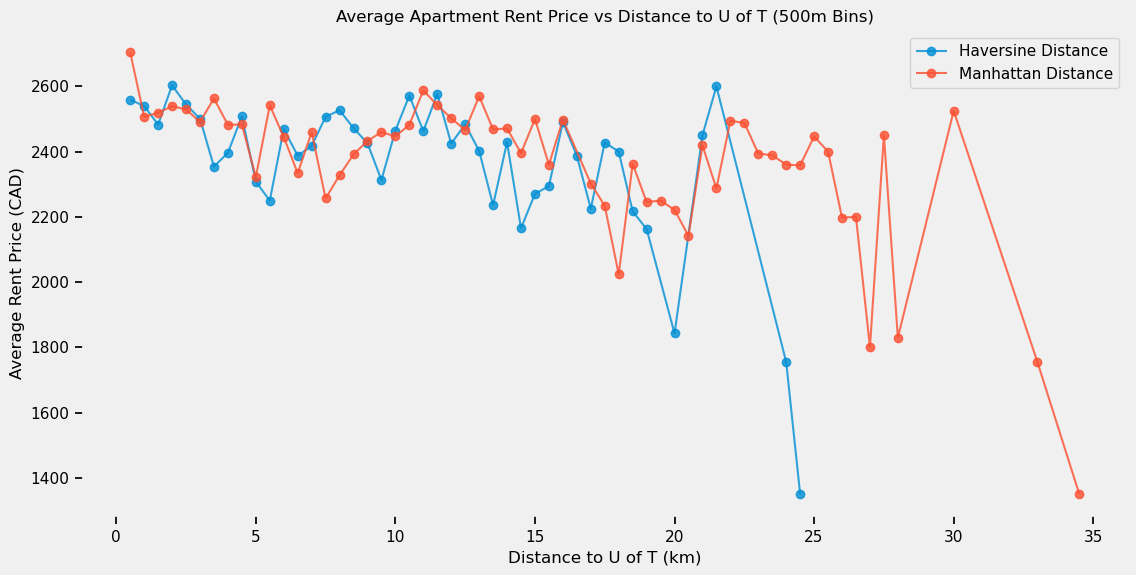

In [205]:
# Bin distances into 500m bins and calculate the average rent price for each bin
df['Haversine Distance Bin (km)'] = (df['Haversine Distance to U of T (km)'] // 0.5) * 0.5
df['Manhattan Distance Bin (km)'] = (df['Manhattan Distance to U of T (km)'] // 0.5) * 0.5

# Calculate the average rent price for each bin
haversine_avg = df.groupby('Haversine Distance Bin (km)')['Rent Price (CAD)'].mean()
manhattan_avg = df.groupby('Manhattan Distance Bin (km)')['Rent Price (CAD)'].mean()

# Plot the average rent price for each distance bin
plt.figure(figsize=(12, 6))
plt.plot(haversine_avg.index, haversine_avg.values, marker='o', label="Haversine Distance", alpha=0.8)
plt.plot(manhattan_avg.index, manhattan_avg.values, marker='o', label="Manhattan Distance", alpha=0.8)
plt.xlabel('Distance to U of T (km)')
plt.ylabel('Average Rent Price (CAD)')
plt.title('Average Apartment Rent Price vs Distance to U of T (500m Bins)')
plt.legend()
plt.grid()
plt.show()

No real trend until more than 10km away from U of T

### 3. Feature Engineering

The column names for the new data set are slightly different than the old one, so I will change the column names so the old code will work.

In [266]:
df = pd.read_csv('Final Data.csv')
df = df.dropna()

In [268]:

# Map the column names from the first table to the second table
column_mapping = {
    'Rent Price (CAD)': 'Rental price',
    'Address': 'Street address',
    'Bedrooms': 'Bedrooms',
    'Bathrooms': 'Bathrooms',
    'Living Area (sqft)': 'Living area',
    'Latitude': 'Latitude',
    'Longitude': 'Longitude',
    'Neighbourhood': 'Neighbourhood',
    'Neighbourhood Rank': 'Neighbourhood Rank',
    '1+0': 1,
    '1+1': 2,
    '1+2': 3,
}

# Update the column names
df = df.rename(columns=column_mapping)

# If there are special cases for 'Bedrooms' formatting:
df['Bedrooms'] = df['Bedrooms'].replace({
    '1+0': 1,
    '1+1': 2,
    '1+2': 3,
}).astype(float)

df.head()


,Listing ID,Street address,Bedrooms,Bathrooms,Living area,Latitude,Longitude,Neighbourhood,Neighbourhood Rank,Rental price
0,2063459583,413 Markham St,1.0,1.0,900.0,43.660350,-79.410310,Palmerston-Little Italy,9.0,2400.0
1,2054131263,1221 King St W,1.0,1.0,500.0,43.638584,-79.427666,South Parkdale,144.0,2200.0
2,2079696219,47 Lower River St,1.0,1.0,500.0,43.656498,-79.355540,Moss Park,69.0,2200.0
3,442326900,120 Rowntree Mill Rd,1.0,1.0,800.0,43.753500,-79.577644,Humber Summit,151.0,1645.0
4,442260890,1100 Sheppard Ave W,1.0,1.0,626.0,43.751930,-79.466700,York University Heights,145.0,2400.0


#### 3.1 Split Data (train/val/test)

The train, val, and test are divided evenly geographically since the data is divided into clusters based on where they are. The resulting sets need to have a proportional amount of data from each cluster.

In [273]:
# Reset the index of the DataFrame to ensure sequential indices
df = df.reset_index(drop=True)

# Define the number of clusters (e.g., 10 clusters)
num_clusters = 3

# Perform clustering on latitude and longitude
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['LocationCluster'] = kmeans.fit_predict(df[['Latitude', 'Longitude']])

# Initialize StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the stratified split for train and temp (which we'll split into validation and test later)
for train_index, temp_index in splitter.split(df, df['LocationCluster']):
    train = df.loc[train_index].reset_index(drop=True)
    temp = df.loc[temp_index].reset_index(drop=True)

# Split temp further into validation and test sets
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_index, test_index in stratified_splitter.split(temp, temp['LocationCluster']):
    val = temp.loc[val_index].reset_index(drop=True)
    test = temp.loc[test_index].reset_index(drop=True)

# Verify the distribution
print("Train set cluster distribution:\n", train['LocationCluster'].value_counts())
print("\nValidation set cluster distribution:\n", val['LocationCluster'].value_counts())
print("\nTest set cluster distribution:\n", test['LocationCluster'].value_counts())

Train set cluster distribution:
 LocationCluster
1    1955
0     457
2     344
Name: count, dtype: int64

Validation set cluster distribution:
 LocationCluster
1    245
0     57
2     43
Name: count, dtype: int64

Test set cluster distribution:
 LocationCluster
1    244
0     58
2     43
Name: count, dtype: int64


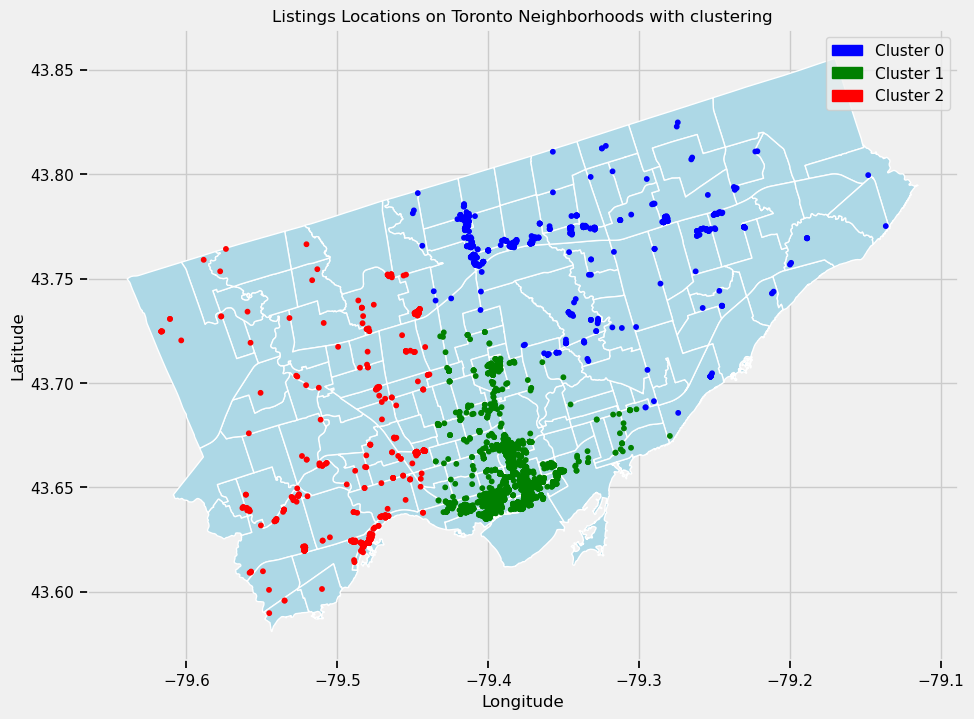

In [275]:
# Plot neighborhoods
fig, ax = plt.subplots(figsize=(10, 10))
neighbourhoods.plot(ax=ax, color='lightblue', edgecolor='white')

# Define colors for each cluster
colors = {0: 'blue', 1: 'green', 2: 'red'}

# Plot listings' locations
plt.scatter(df['Longitude'],df['Latitude'], c=df['LocationCluster'].map(colors), s=10, label="Listing Location")

# Add labels and legend
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(handles=[mpatches.Patch(color=color, label=f'Cluster {i}') for i, color in colors.items()])
plt.title("Listings Locations on Toronto Neighborhoods with clustering")

plt.show()

In [277]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3446 entries, 0 to 3445
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Listing ID          3446 non-null   object 
 1   Street address      3446 non-null   object 
 2   Bedrooms            3446 non-null   float64
 3   Bathrooms           3446 non-null   float64
 4   Living area         3446 non-null   float64
 5   Latitude            3446 non-null   float64
 6   Longitude           3446 non-null   float64
 7   Neighbourhood       3446 non-null   object 
 8   Neighbourhood Rank  3446 non-null   float64
 9   Rental price        3446 non-null   float64
 10  LocationCluster     3446 non-null   int32  
dtypes: float64(7), int32(1), object(3)
memory usage: 282.8+ KB


**preprocess_data function (split and remove outliers)**

In [281]:

def preprocess_data(df, price_threshold=12000, area_threshold=5000, 
                                     test_size=0.2, val_size=0.2, n_clusters=3, random_state=42):
  
    # Step 1: Remove outliers
    filtered_df = df[(df['Rental price'] <= price_threshold) & (df['Living area'] <= area_threshold)]

    # Step 2: Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    filtered_df['Cluster'] = kmeans.fit_predict(filtered_df[['Latitude', 'Longitude']])
    
    # Step 3: Split based on clustering
    train_val, test = train_test_split(
        filtered_df, test_size=test_size, random_state=random_state, stratify=filtered_df['Cluster']
    )

    # Adjust val_size relative to train+val
    val_size_adjusted = val_size / (1 - test_size)

    train, val = train_test_split(
        train_val, test_size=val_size_adjusted, random_state=random_state, stratify=train_val['Cluster']
    )

    # Drop the 'Cluster' column before returning
    train = train.drop(columns=['Cluster'])
    val = val.drop(columns=['Cluster'])
    test = test.drop(columns=['Cluster'])

    return train, val, test



In [283]:
train, val, test = preprocess_data(
    df,
    price_threshold=12000,  # Define outlier thresholds for rental price
    area_threshold=5000,    # Define outlier thresholds for living area 
    test_size=0.2,          # 20% test set
    val_size=0.2,           # 20% of train+val for validation
    n_clusters=3,          # Number of KMeans clusters
    random_state=42
)

print(f"Train Size: {len(train)}, Validation Size: {len(val)}, Test Size: {len(test)}")

Train Size: 2067, Validation Size: 689, Test Size: 690


**Training Set**

<Axes: >

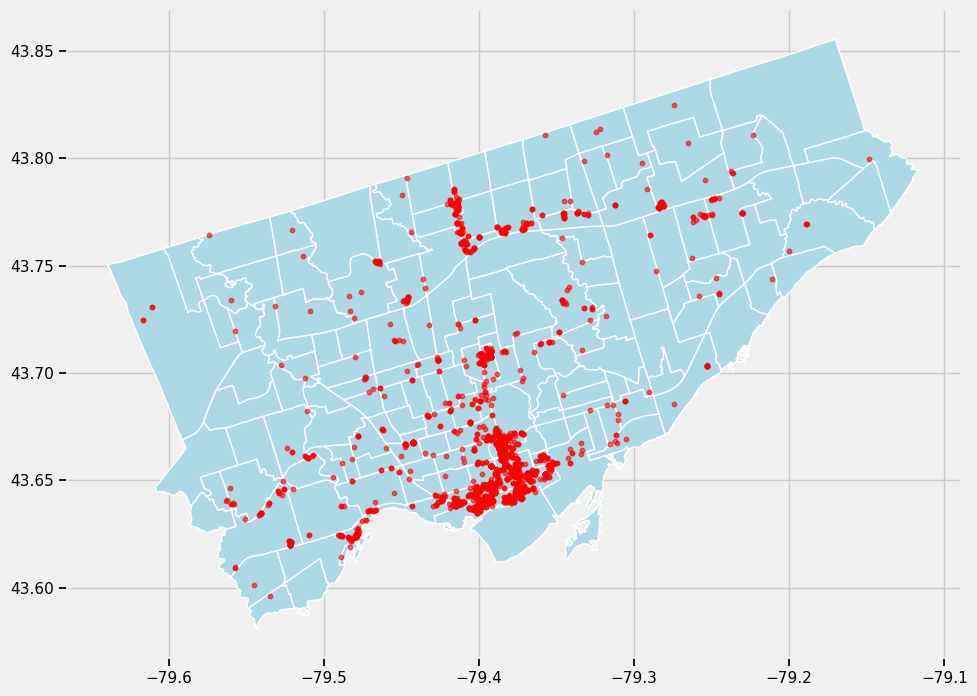

In [286]:
geometry = [Point(xy) for xy in zip(train['Longitude'], train['Latitude'])]
train_gdf = gpd.GeoDataFrame(train, geometry=geometry, crs='EPSG:4326')

# Plot the map with neighborhood boundaries
fig, ax = plt.subplots(figsize=(12, 8))
neighbourhoods.plot(ax=ax, color='lightblue', edgecolor='white')

# Overlay the apartment locations from the training set
train_gdf.plot(ax=ax, color='red', markersize=10, label="Train Set Locations", alpha=0.6)

**Validation set**

<Axes: >

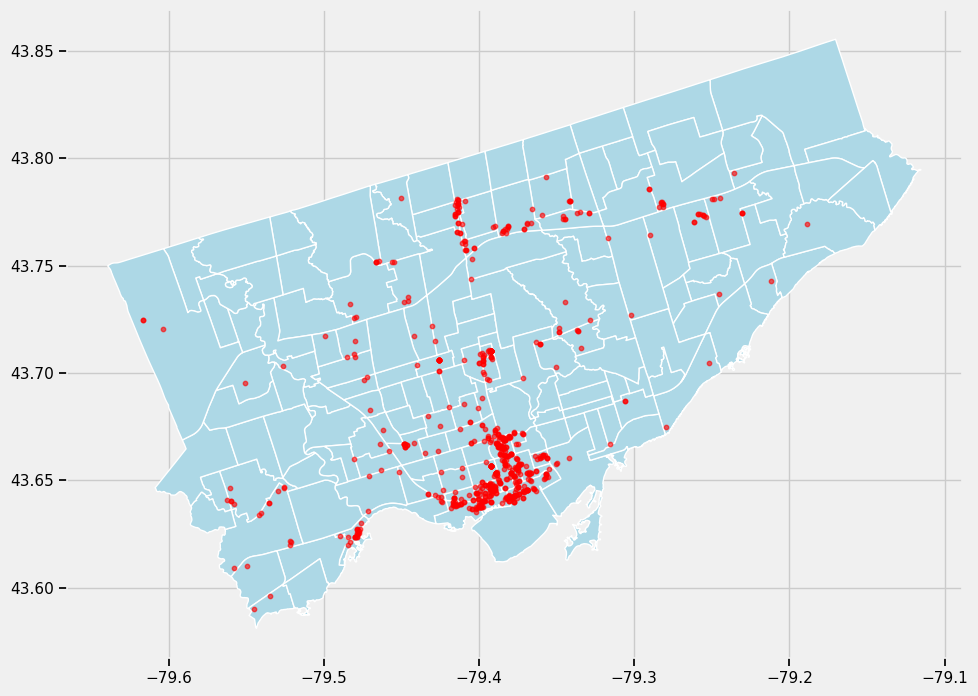

In [289]:
geometry = [Point(xy) for xy in zip(val['Longitude'], val['Latitude'])]
val_gdf = gpd.GeoDataFrame(val, geometry=geometry, crs='EPSG:4326')

# Plot the map with neighborhood boundaries
fig, ax = plt.subplots(figsize=(12, 8))
neighbourhoods.plot(ax=ax, color='lightblue', edgecolor='white')

# Overlay the apartment locations from the training set
val_gdf.plot(ax=ax, color='red', markersize=10, label="Train Set Locations", alpha=0.6)

#### 3.2 Create Features

In [292]:
def create_features(df):
    # Drop the Property URL column
    df = df.drop(columns=['Property URL'], errors='ignore')
    
    # Step 1: Apply PCA to Latitude and Longitude to create PC1
    pca = PCA(n_components=1)
    df[['Latitude', 'Longitude']] = df[['Latitude', 'Longitude']].fillna(df[['Latitude', 'Longitude']].mean())
    df['PC1'] = pca.fit_transform(df[['Latitude', 'Longitude']])
    
    # Step 2: Select relevant features (no dummy encoding for Bedrooms and Bathrooms)
    feature_df = df[['Bedrooms', 'Bathrooms', 'Neighbourhood Rank', 'Living area', 'PC1']]
    
    # Step 3: Normalize all features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_df)
    scaled_feature_df = pd.DataFrame(scaled_features, columns=feature_df.columns)
    
    return scaled_feature_df

# Example Usage:
# Apply the function to the dataset
features = create_features(train)
print(features.head())

   Bedrooms  Bathrooms  Neighbourhood Rank  Living area       PC1
0  1.087605  -0.353971            1.929912     0.427109  1.226944
1 -0.901846  -0.353971           -1.132894     0.427109 -0.337511
2 -0.901846  -0.353971            0.162909    -2.041443  0.107699
3  1.087605  -0.353971            0.280709     0.427109  0.132097
4 -0.901846  -0.353971            0.928610    -0.190029 -0.146310


#### 3.3 Investigate Features

##### 3.3.1 Feature Importance from a Random Forest

              Feature  Importance
4                 PC1    0.356191
3         Living area    0.340315
2  Neighbourhood Rank    0.188198
0            Bedrooms    0.072269
1           Bathrooms    0.043027


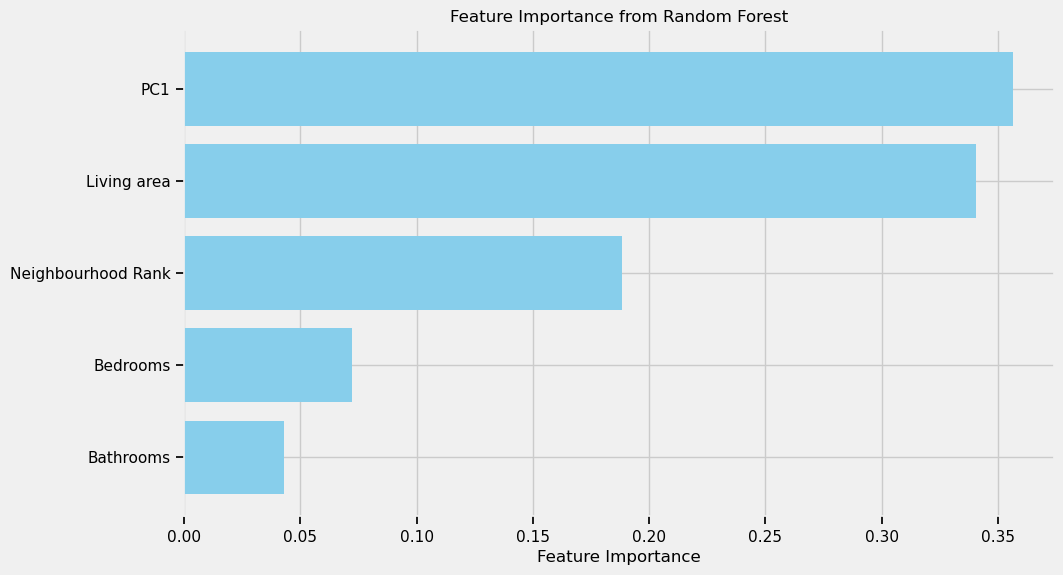

In [296]:
X = features
y = train['Rental price']

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X, y)

# Extract feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display feature importances
print(feature_importances)

# Plot the feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance on top
plt.show()

#####  3.3.2 Correlation with Target Variable

Bedrooms             -0.007787
Bathrooms            -0.017630
Living area          -0.021693
Neighbourhood Rank   -0.044793
PC1                  -0.051910
Name: Rental price, dtype: float64


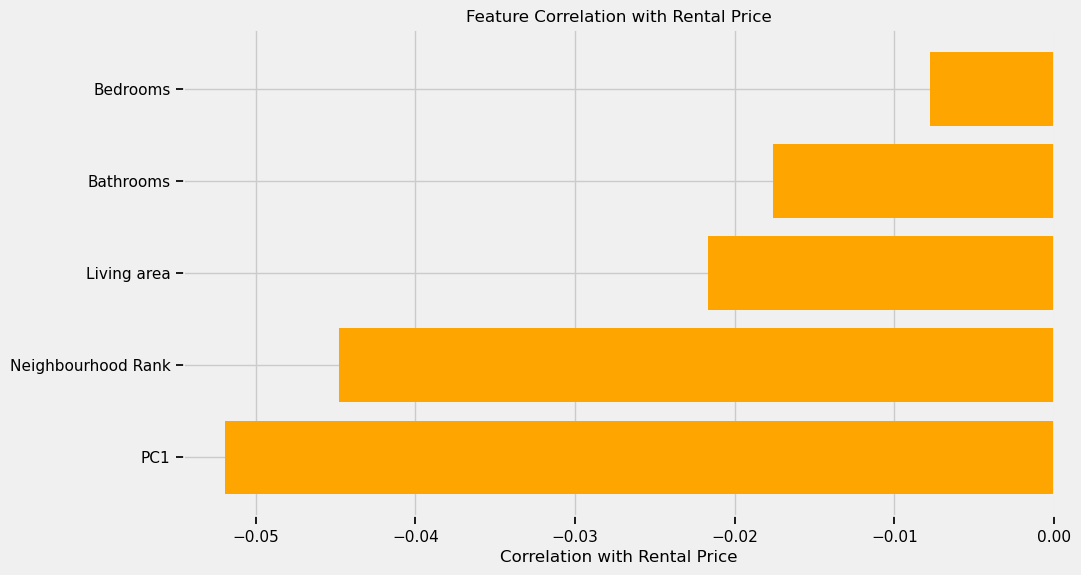

In [300]:
# Compute correlation with the target variable
correlations = X.join(y).corr()['Rental price'].drop('Rental price')

# Display correlations
correlations = correlations.sort_values(ascending=False)
print(correlations)

# Plot the correlations
plt.figure(figsize=(10, 6))
plt.barh(correlations.index, correlations.values, color='orange')
plt.xlabel('Correlation with Rental Price')
plt.title('Feature Correlation with Rental Price')
plt.gca().invert_yaxis()
plt.show()

##### 3.3.3 Permutation Importance 

This measures the decrease in model performance when a feature's values are randomly shuffled, making it useless.

              Feature  Importance
3         Living area    0.816863
4                 PC1    0.488717
2  Neighbourhood Rank    0.380701
0            Bedrooms    0.284925
1           Bathrooms    0.132815


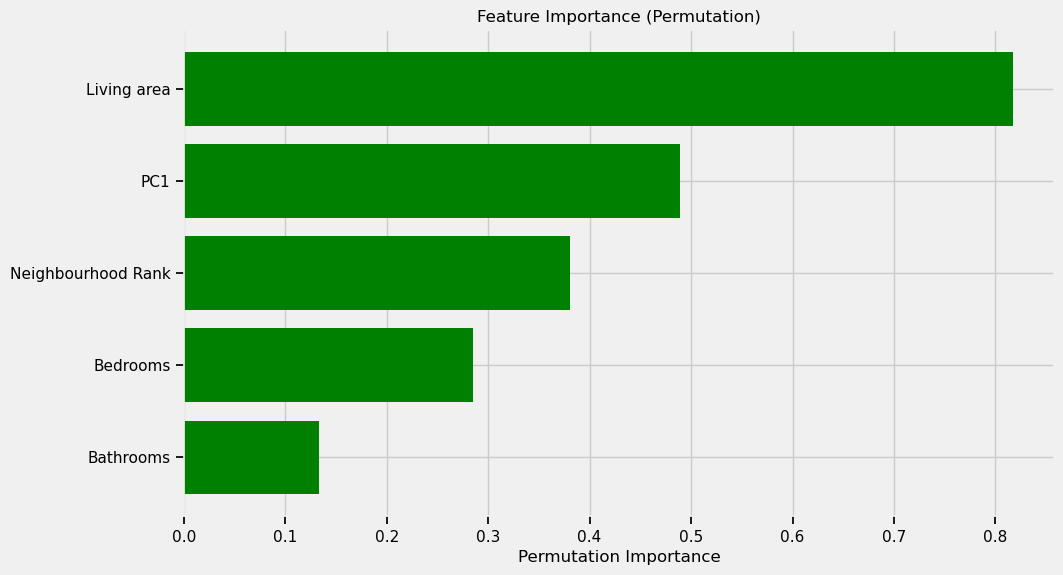

In [304]:
# Compute permutation importance
perm_importance = permutation_importance(rf_model, X, y, n_repeats=10, random_state=42)

# Extract results
perm_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance['importances_mean']
}).sort_values(by='Importance', ascending=False)

# Display permutation importances
print(perm_importance_df)

# Plot the permutation importances
plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df['Feature'], perm_importance_df['Importance'], color='green')
plt.xlabel('Permutation Importance')
plt.title('Feature Importance (Permutation)')
plt.gca().invert_yaxis()
plt.show()

##### 3.3.4 Check for Redundant Features

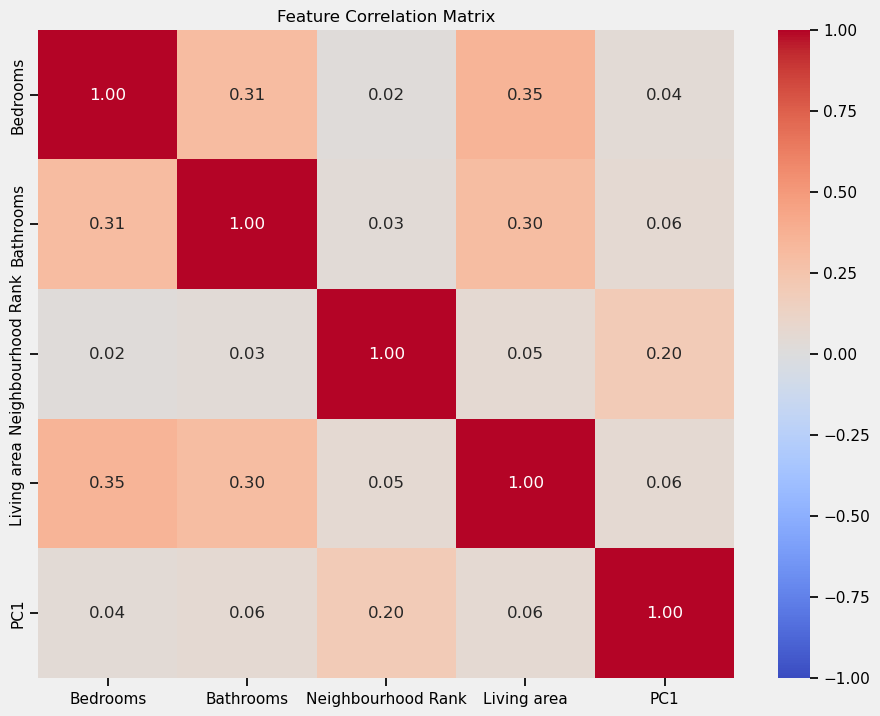

Highly Correlated Features:
Empty DataFrame
Columns: [Bedrooms, Bathrooms, Neighbourhood Rank, Living area, PC1]
Index: []


In [307]:
# Calculate the correlation matrix
correlation_matrix = features.corr()

# Plot a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.show()

# Identify highly correlated pairs (absolute correlation > 0.9)
high_correlation = correlation_matrix[(correlation_matrix.abs() > 0.9) & (correlation_matrix.abs() < 1)]
print("Highly Correlated Features:")
print(high_correlation.dropna(how='all'))

No features are highly redundant since the correlations are all lower than 0.9

#### 3.4 Mutiple different version of create_features function that keeps different features

##### 3.4.1 No PC1

In [312]:
def create_features_without_pc1(df):
    # Drop the Property URL column
    df = df.drop(columns=['Property URL'], errors='ignore')
    
    # Select relevant features (excluding PC1 creation)
    feature_df = df[['Bedrooms', 'Bathrooms', 'Neighbourhood Rank', 'Living area']]
    
    # Normalize all features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_df)
    scaled_feature_df = pd.DataFrame(scaled_features, columns=feature_df.columns)
    
    return scaled_feature_df

##### 3.4.2 Only Bedrooms, Living area, and Neighbourhood Rank

In [315]:
def create_features_living_bedrooms_rank(df):
    # Drop the Property URL column
    df = df.drop(columns=['Property URL'], errors='ignore')
    
    # Select relevant features (Living area, Bedrooms, Neighbourhood Rank)
    feature_df = df[['Living area', 'Bedrooms', 'Neighbourhood Rank']]
    
    # Normalize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_df)
    scaled_feature_df = pd.DataFrame(scaled_features, columns=feature_df.columns)
    
    return scaled_feature_df

##### 3.4.3 Only bedroom number and living area

In [318]:
def create_features_living_bedrooms(df):
    # Drop the Property URL column
    df = df.drop(columns=['Property URL'], errors='ignore')
    
    # Select relevant features (only Living area and Bedrooms)
    feature_df = df[['Living area', 'Bedrooms']]
    
    # Normalize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_df)
    scaled_feature_df = pd.DataFrame(scaled_features, columns=feature_df.columns)
    
    return scaled_feature_df

### 4. Modeling

#### 4.1 Simple Model (Always Predicts the Mean)

In [322]:
# Calculate the mean rent from the training set
mean_rent = train['Rental price'].mean()

# Create baseline predictions for both training and validation sets
y_train_baseline = np.full_like(train['Rental price'], fill_value=mean_rent)
y_val_baseline = np.full_like(val['Rental price'], fill_value=mean_rent)

# Calculate RMSE for training and validation sets
train_rmse = np.sqrt(mean_squared_error(train['Rental price'], y_train_baseline))
val_rmse = np.sqrt(mean_squared_error(val['Rental price'], y_val_baseline))

# Calculate R² for training and validation sets
train_r2 = r2_score(train['Rental price'], y_train_baseline)
val_r2 = r2_score(val['Rental price'], y_val_baseline)

# Display results
print("Baseline Model Performance:")
print(f"Training RMSE: {train_rmse:.2f}, Training R²: {train_r2:.2f}")
print(f"Validation RMSE: {val_rmse:.2f}, Validation R²: {val_r2:.2f}")

Baseline Model Performance:
Training RMSE: 344.79, Training R²: 0.00
Validation RMSE: 413.15, Validation R²: -0.00


#### 4.2 Linear Model

In [325]:
from sklearn.linear_model import LinearRegression
# Prepare training and validation sets
X_train = create_features(train)  # Replace with chosen create features function
y_train = train['Rental price']

X_val = create_features(val)  # Replace with your chosen create features function
y_val = val['Rental price']

# Initialize the Linear Regression model
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train, y_train)

# Make predictions
y_train_pred = lr_model.predict(X_train)
y_val_pred = lr_model.predict(X_val)

# Evaluate the model on the training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# Evaluate the model on the validation set
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

# Print results
print("Linear Regression Model Performance:")
print(f"Training RMSE: {train_rmse:.2f}, Training R²: {train_r2:.2f}")
print(f"Validation RMSE: {val_rmse:.2f}, Validation R²: {val_r2:.2f}")

Linear Regression Model Performance:
Training RMSE: 286.26, Training R²: 0.31
Validation RMSE: 362.83, Validation R²: 0.23


#### 4.3 Random Forest Model

In [347]:
# Prepare training and validation features and target
X_train = create_features(train)  # Replace with your chosen feature function, there are multiple version in this notebook
y_train = train['Rental price']

X_val = create_features(val)  # Replace with your chosen feature function
y_val = val['Rental price']

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=200,         # Number of trees in the forest
    max_depth=10,             # Maximum depth of each tree
    min_samples_split=2,      # Minimum samples required to split an internal node
    min_samples_leaf=2,       # Minimum samples required to be at a leaf node
    max_features=None,      # Number of features to consider for the best split
    random_state=42           # Random seed for reproducibility
)
rf_model.fit(X_train, y_train)

# Make predictions on training and validation sets
y_train_pred = rf_model.predict(X_train)
y_val_pred = rf_model.predict(X_val)

# Calculate RMSE and R² for training and validation sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

# Display results
print("Random Forest Model Performance:")
print(f"Training RMSE: {train_rmse:.2f}, Training R²: {train_r2:.2f}")
print(f"Validation RMSE: {val_rmse:.2f}, Validation R²: {val_r2:.2f}")

Random Forest Model Performance:
Training RMSE: 183.80, Training R²: 0.72
Validation RMSE: 355.85, Validation R²: 0.26


#### 4.3.1 Hyperparameters. Go back and forth between this step and the random forest to find the best model (need Nicolas's data set for this)

In [337]:
from sklearn.model_selection import GridSearchCV
# Define a custom scoring function for RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Convert the function to a scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)  # False because lower RMSE is better

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 20, 40],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None],
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Set up GridSearchCV with RMSE scoring
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring=rmse_scorer, verbose=2)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the corresponding RMSE
best_params = grid_search.best_params_
best_rmse = -grid_search.best_score_  # Negate because `greater_is_better=False`

print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Best Parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE: 264.5143648855414


In [332]:
#Perform cross-validation 
cv_results = cross_validate(
    estimator=rf_model,
    X=X_train,  # Features
    y=y_train,  # Target
    scoring={'RMSE': rmse_scorer, 'R2': 'r2'},  # Calculate RMSE and R²
    cv=5,  # Number of folds
    n_jobs=1,  
    return_train_score=True  # Include training scores
)

# Extract RMSE and R² scores
train_rmse = -cv_results['train_RMSE']  # Negate RMSE to make it positive
val_rmse = -cv_results['test_RMSE']     # Negate RMSE to make it positive
train_r2 = cv_results['train_R2']
val_r2 = cv_results['test_R2']

# Compute mean and standard deviation
train_rmse_mean = np.mean(train_rmse)
train_rmse_std = np.std(train_rmse)
val_rmse_mean = np.mean(val_rmse)
val_rmse_std = np.std(val_rmse)

train_r2_mean = np.mean(train_r2)
train_r2_std = np.std(train_r2)
val_r2_mean = np.mean(val_r2)
val_r2_std = np.std(val_r2)

# Print results
print("Mean Training RMSE:", train_rmse_mean, "±", train_rmse_std)
print("Mean Validation RMSE:", val_rmse_mean, "±", val_rmse_std)

print("Mean Training R²:", train_r2_mean, "±", train_r2_std)
print("Mean Validation R²:", val_r2_mean, "±", val_r2_std)

Mean Training RMSE: 173.19655381900088 ± 2.084777878409041
Mean Validation RMSE: 268.5716978571858 ± 14.54737008049854
Mean Training R²: 0.7474092666170223 ± 0.009620527018493127
Mean Validation R²: 0.3899936940025691 ± 0.02569088573861359


#### 4.4 Final Model

### 5. Prediction